In [311]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df=pd.read_csv("./playground-series-s5e5/train.csv")
test_df=pd.read_csv("./playground-series-s5e5/test.csv")

In [4]:
train_df['Sex']=train_df['Sex'].apply(lambda x: 1 if x=="male" else 0)
test_df['Sex']=test_df['Sex'].apply(lambda x: 1 if x=="male" else 0)

In [5]:
test_ids=test_df['id']

In [6]:
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

In [7]:
def detecting_outliers(val):
    sns.boxplot(x=f'{val}', data=train_df)
    plt.title("Box plot")
    plt.show()

In [8]:
def get_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def cap_outliers_with_bounds(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for col in numerical_cols:
    lower, upper = get_iqr_bounds(train_df, col)
    train_df = cap_outliers_with_bounds(train_df, col, lower, upper)
    test_df = cap_outliers_with_bounds(test_df, col, lower, upper)

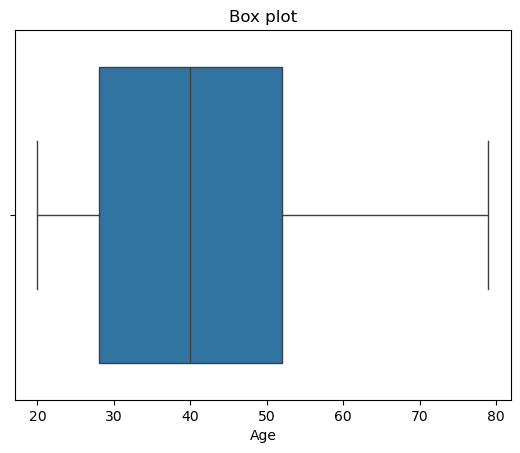

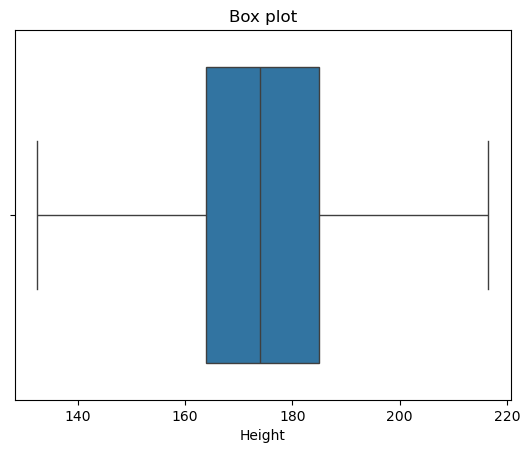

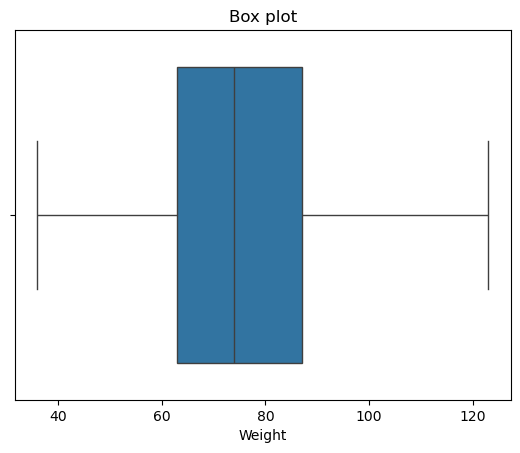

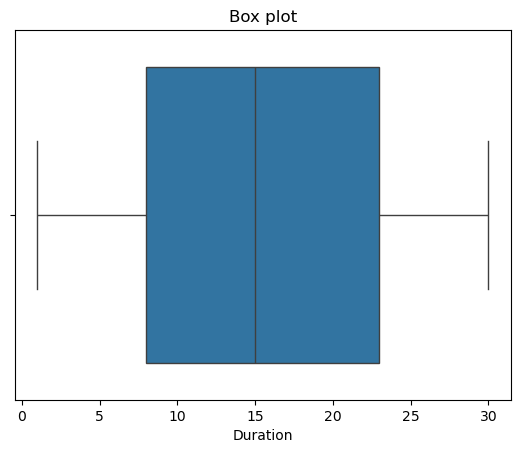

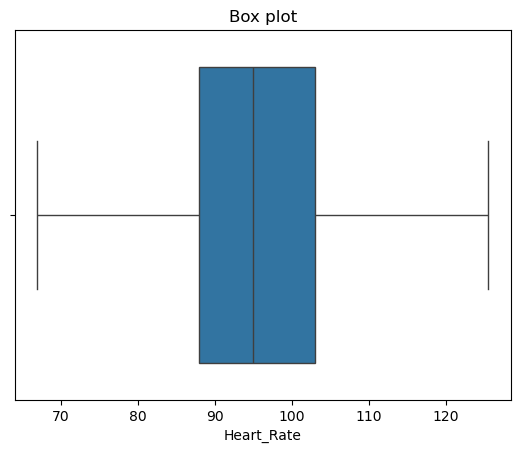

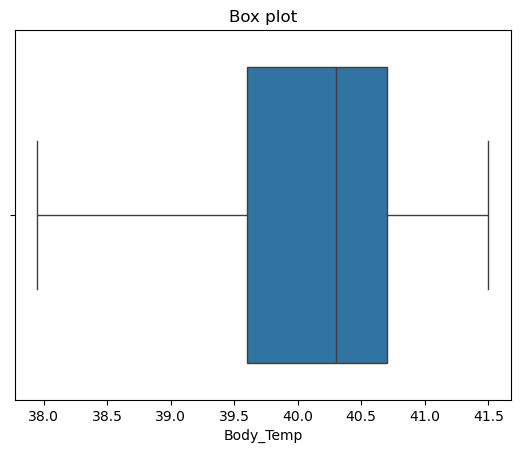

In [9]:
detecting_outliers('Age')
detecting_outliers('Height')
detecting_outliers('Weight')
detecting_outliers('Duration')
detecting_outliers('Heart_Rate')
detecting_outliers('Body_Temp')

In [10]:
train_df1=train_df.copy()
test_df1=test_df.copy()

In [11]:
train_df1.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0


In [12]:
#Train data
train_df1['Duration^2']=train_df1['Duration']**2
train_df1['Weight/Duration']=train_df1['Weight']/train_df1['Duration']
train_df1['Duration/Age']=train_df1['Duration']/train_df1['Age']
#train_df1['Age^2']=train_df1['Age']**2
train_df1['Duration_x_Hear_Rate']=train_df1['Duration']*train_df1['Heart_Rate']

#Test data
test_df1['Duration^2']=test_df1['Duration']**2
test_df1['Weight/Duration']=test_df1['Weight']/test_df1['Duration']
test_df1['Duration/Age']=test_df1['Duration']/test_df1['Age']
#test_df1['Age^2']=test_df1['Age']**2
test_df1['Duration_x_Hear_Rate']=test_df1['Duration']*test_df1['Heart_Rate']

In [13]:
X1=train_df1.drop(columns=['Calories'])
y1=train_df1['Calories']

In [14]:
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, test_size=0.2)

In [15]:
scaler=StandardScaler()

X1_train_scaled=scaler.fit_transform(X1_train)
X1_test_scaled=scaler.transform(X1_test)

test_df1_scaled=scaler.transform(test_df1)

In [16]:
y1_train_log = np.log1p(y1_train)
y1_test_log = np.log1p(y1_test)

In [17]:
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X1_train_scaled, y1_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 11
[LightGBM] [Info] Start training from score 4.140400


LGBMRegressor(random_state=42)

In [18]:
lgb_pred_log = lgb_model.predict(X1_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [19]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.060718663568554994


In [20]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X1_train_scaled, y1_train_log)

In [21]:
cat_pred_log = cat_model.predict(X1_test_scaled)
cat_pred = np.expm1(cat_pred_log)

In [22]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.05855545489244012


In [23]:
predictions10=cat_model.predict(test_df1_scaled)
predictions10=np.expm1(predictions10)

In [24]:
submission10=pd.DataFrame({'id': test_ids, 'Calories': predictions10})
submission10.to_csv('submission10.csv', index=False)
print("Submission10 file created")

Submission10 file created


In [25]:
rf_model=RandomForestRegressor(verbose=0, random_state=42)
rf_model.fit(X1_train_scaled, y1_train_log)

RandomForestRegressor(random_state=42)

In [26]:
rf_pred_log=rf_model.predict(X1_test_scaled)
rf_pred=np.expm1(rf_pred_log)

In [27]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, rf_pred))
print("Random Forest RMSLE:", rmsle)

Random Forest RMSLE: 0.06222728805201796


In [28]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X1_train_scaled, y1_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
xgb_pred_log = xgb_model.predict(X1_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [30]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06073775214571883


In [31]:
blended_pred_log = 0.2 * lgb_pred_log + 0.7 * cat_pred_log + 0.1 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y1_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05846663127990764


In [32]:
lgb_test_log = lgb_model.predict(test_df1_scaled)
cat_test_log = cat_model.predict(test_df1_scaled)
xgb_test_log = xgb_model.predict(test_df1_scaled)

# Blend and reverse transform
final_pred_log = 0.1 * lgb_test_log + 0.8 * cat_test_log + 0.1 * xgb_test_log

In [33]:
predictions13=np.expm1(final_pred_log)

In [34]:
submission13=pd.DataFrame({'id': test_ids, 'Calories': predictions13})
submission13.to_csv('submission13.csv', index=False)
print("Submission13 file created")

Submission13 file created


### Rank: 571/1919

In [36]:
train_df2=train_df.copy()
test_df2=test_df.copy()

In [37]:
train_df2['Duration^2']=train_df2['Duration']**2
test_df2['Duration^2']=test_df2['Duration']**2

In [38]:
train_df2.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0


In [39]:
test_df2.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Duration^2
0,1,45,177.0,81.0,7.0,87.0,39.8,49.0
1,1,26,200.0,97.0,20.0,101.0,40.5,400.0
2,0,29,188.0,85.0,16.0,102.0,40.4,256.0
3,0,39,172.0,73.0,20.0,107.0,40.6,400.0
4,0,30,173.0,67.0,16.0,94.0,40.5,256.0


In [40]:
X2=train_df2.drop(columns=['Calories'])
y2=train_df2['Calories']

In [41]:
X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.2)

In [42]:
scaler=StandardScaler()

X2_train_scaled=scaler.fit_transform(X2_train)
X2_test_scaled=scaler.transform(X2_test)

test_df2_scaled=scaler.transform(test_df2)

In [43]:
y2_train_log = np.log1p(y2_train)
y2_test_log = np.log1p(y2_test)

In [44]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X2_train_scaled, y2_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 8
[LightGBM] [Info] Start training from score 4.140585


LGBMRegressor(random_state=42)

In [45]:
lgb_pred_log = lgb_model.predict(X2_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [46]:
rmsle = np.sqrt(mean_squared_log_error(y2_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.06261551736286106


In [47]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X2_train_scaled, y2_train_log)

In [48]:
cat_pred_log = cat_model.predict(X2_test_scaled)
cat_pred = np.expm1(cat_pred_log)

In [49]:
rmsle = np.sqrt(mean_squared_log_error(y2_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.059969863113231395


In [50]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X2_train_scaled, y2_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
xgb_pred_log = xgb_model.predict(X2_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [52]:
rmsle = np.sqrt(mean_squared_log_error(y2_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06248814978314216


In [53]:
blended_pred_log = 0.1 * lgb_pred_log + 0.8 * cat_pred_log + 0.1 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y2_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05988451080044499


In [54]:
lgb_test_log = lgb_model.predict(test_df2_scaled)
cat_test_log = cat_model.predict(test_df2_scaled)
xgb_test_log = xgb_model.predict(test_df2_scaled)


final_pred_log = 0.1 * lgb_test_log + 0.8 * cat_test_log + 0.1 * xgb_test_log

In [55]:
predictions15=np.expm1(final_pred_log)

In [56]:
submission15=pd.DataFrame({'id': test_ids, 'Calories': predictions15})
submission15.to_csv('submission15.csv', index=False)
print("Submission15 file created")

Submission15 file created


## Rank: 331/2049

## Rank: 437/1923

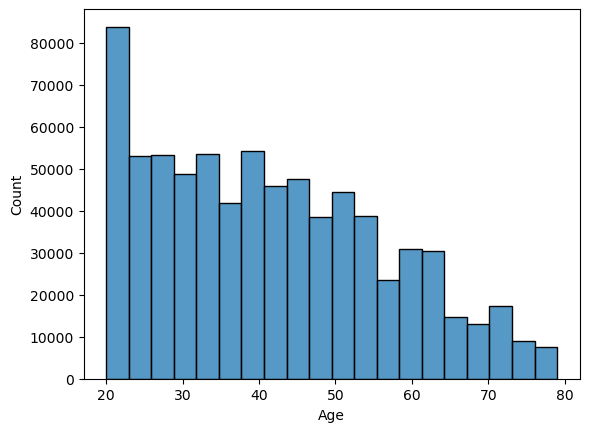

In [59]:
sns.histplot(train_df['Age'], bins=20)
plt.show()

In [60]:
train_df2['Age_bin']=pd.cut(train_df2['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

In [61]:
test_df2['Age_bin']=pd.cut(test_df2['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

In [62]:
train_df2.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2,Age_bin
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0,2
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0,5
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0,4
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0,0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0,2


In [63]:
train_df3=train_df.copy()
test_df3=test_df.copy()

In [64]:
train_df3['Duration^2']=train_df3['Duration']**2
train_df3['Age_bin']=pd.cut(train_df3['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
train_df3['Duration_x_Age_bin']=train_df3['Duration']*train_df3['Age_bin']

test_df3['Duration^2']=test_df3['Duration']**2
test_df3['Age_bin']=pd.cut(test_df3['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
test_df3['Duration_x_Age_bin']=test_df3['Duration']*test_df3['Age_bin']

In [65]:
X3=train_df3.drop(columns=['Calories'])
y3=train_df3['Calories']

In [66]:
X3_train, X3_test, y3_train, y3_test=train_test_split(X3, y3, test_size=0.2)

In [67]:
scaler=StandardScaler()

X3_train_scaled=scaler.fit_transform(X3_train)
X3_test_scaled=scaler.transform(X3_test)

test_df3_scaled=scaler.transform(test_df3)

In [68]:
y3_train_log = np.log1p(y3_train)
y3_test_log = np.log1p(y3_test)

In [69]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X3_train_scaled, y3_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 10
[LightGBM] [Info] Start training from score 4.141581


LGBMRegressor(random_state=42)

In [70]:
lgb_pred_log = lgb_model.predict(X3_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [71]:
rmsle = np.sqrt(mean_squared_log_error(y3_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.06196230525528241


In [72]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X3_train_scaled, y3_train_log)

In [73]:
cat_pred_log = cat_model.predict(X3_test_scaled)
cat_pred = np.expm1(cat_pred_log)

In [74]:
rmsle = np.sqrt(mean_squared_log_error(y3_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.059403005024265744


In [75]:
predictions16=cat_model.predict(test_df3_scaled)
predictions16=np.expm1(predictions16)

In [76]:
submission16=pd.DataFrame({'id': test_ids, 'Calories': predictions16})
submission16.to_csv('submission16.csv', index=False)
print("Submission16 file created")

Submission16 file created


In [77]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X3_train_scaled, y3_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [78]:
xgb_pred_log = xgb_model.predict(X3_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [79]:
rmsle = np.sqrt(mean_squared_log_error(y3_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06247143631223087


In [80]:
blended_pred_log =  0.8 * cat_pred_log + 0.2 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y3_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05944307188253821


In [81]:
cat_test_log = cat_model.predict(test_df3_scaled)
xgb_test_log = xgb_model.predict(test_df3_scaled)


final_pred_log = 0.8 * cat_test_log + 0.2 * xgb_test_log

In [82]:
predictions17=np.expm1(final_pred_log)

In [83]:
submission17=pd.DataFrame({'id': test_ids, 'Calories': predictions17})
submission17.to_csv('submission17.csv', index=False)
print("Submission17 file created")

Submission17 file created


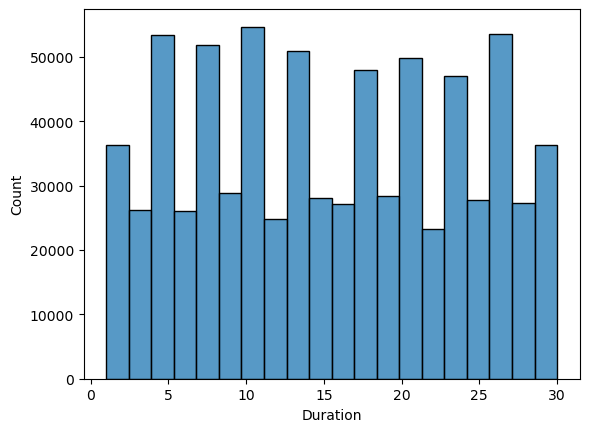

In [179]:
sns.histplot(train_df['Duration'], bins=20)
plt.show()

In [295]:
train_df5=train_df.copy()
test_df5=test_df2.copy()

In [297]:
train_df5['Duration^2']=train_df5['Duration']**2
train_df5['Age_bin']=pd.cut(train_df5['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

test_df5['Duration^2']=test_df5['Duration']**2
test_df5['Age_bin']=pd.cut(test_df5['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)

In [309]:
X5=train_df5.drop(columns=['Calories'])
y5=train_df5['Calories']

In [315]:
X5_train, X5_test, y5_train, y5_test=train_test_split(X5, y5, test_size=0.2)

In [373]:
scaler=StandardScaler()

X5_train_scaled=scaler.fit_transform(X5_train)
X5_test_scaled=scaler.transform(X5_test)

test_df5_scaled=scaler.transform(test_df5)

In [317]:
y5_train_log = np.log1p(y5_train)
y5_test_log = np.log1p(y5_test)

In [415]:
train_pool = Pool(X5_train_scaled, label=y5_train_log)
eval_pool = Pool(X5_test_scaled, label=y5_test_log)

In [417]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    bootstrap_type='Bayesian',
    random_state=42
)
cat_model.fit(train_pool, eval_set=eval_pool, use_best_model=True)

0:	learn: 0.9184754	test: 0.9171129	best: 0.9171129 (0)	total: 25.4ms	remaining: 25.3s
1:	learn: 0.8756704	test: 0.8743549	best: 0.8743549 (1)	total: 39.2ms	remaining: 19.6s
2:	learn: 0.8352848	test: 0.8340287	best: 0.8340287 (2)	total: 52.8ms	remaining: 17.5s
3:	learn: 0.7967766	test: 0.7955937	best: 0.7955937 (3)	total: 67.2ms	remaining: 16.7s
4:	learn: 0.7603192	test: 0.7591742	best: 0.7591742 (4)	total: 83.1ms	remaining: 16.5s
5:	learn: 0.7252960	test: 0.7241636	best: 0.7241636 (5)	total: 97.1ms	remaining: 16.1s
6:	learn: 0.6922595	test: 0.6911599	best: 0.6911599 (6)	total: 111ms	remaining: 15.7s
7:	learn: 0.6610677	test: 0.6599877	best: 0.6599877 (7)	total: 125ms	remaining: 15.4s
8:	learn: 0.6311443	test: 0.6300883	best: 0.6300883 (8)	total: 139ms	remaining: 15.3s
9:	learn: 0.6027490	test: 0.6017468	best: 0.6017468 (9)	total: 152ms	remaining: 15.1s
10:	learn: 0.5757036	test: 0.5747160	best: 0.5747160 (10)	total: 166ms	remaining: 15s
11:	learn: 0.5500292	test: 0.5490669	best: 0.549

In [419]:
cat_pred_log = cat_model.predict(X5_test_scaled)
y_pred = np.expm1(cat_pred_log)

In [421]:
rmsle = np.sqrt(mean_squared_log_error(y5_test, y_pred))
print("Tuned CatBoost RMSLE:", rmsle)

Tuned CatBoost RMSLE: 0.05983170005518162


In [375]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X5_train_scaled, y5_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 9
[LightGBM] [Info] Start training from score 4.141145


LGBMRegressor(random_state=42)

In [379]:
lgb_pred_log = lgb_model.predict(X5_test_scaled)
lgb_pred = np.expm1(lgb_pred_log)

In [381]:
rmsle = np.sqrt(mean_squared_log_error(y5_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.06269461667189033


In [383]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X5_train_scaled, y5_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [387]:
xgb_pred_log = xgb_model.predict(X5_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

In [389]:
rmsle = np.sqrt(mean_squared_log_error(y5_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06222001121768398


In [413]:
blended_pred_log =  0.1 * lgb_pred_log + 0.8 * cat_pred_log + 0.1 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y5_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.059734108372146315
